# Data Cleaning - Airbnb Calendar Data

## Introduction

In the following notebook, I'll be cleaning up the calendar data SF_Calendar_Nov2018_Oct2019.csv

**Read in necessary libraries**

In [11]:
#Read in libraries
import dask.dataframe as dd
import swifter

import pandas as pd

import re

import numpy as np
from scipy import stats

import seaborn as sns
import plotly.express as px

**Set Additional Settings for Notebook**

In [12]:
#Set plot aesthetics for notebook
sns.set(style='whitegrid', palette='pastel', color_codes=True)

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#supress future warnings
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)

**Read in Data**

In [13]:
#Set path to get aggregated Calendar data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\SF Airbnb Raw Data - Aggregated\SF_Calendar_Nov2018_Oct2019.csv'

#Parse dates
parse_dates = ['date']

#Read in calendar and reviews data
calendar = pd.read_csv(path, sep = '\t', parse_dates=parse_dates,index_col=0, low_memory=False)

## Data Preview

In [14]:
#Preview calendar data
display(calendar.head())

,adjusted_price,available,date,listing_id,maximum_nights,minimum_nights,price
0,$80.00,f,2019-04-03,187730,120.0,3.0,$80.00
1,$80.00,f,2019-04-04,187730,120.0,3.0,$80.00
2,$82.00,t,2019-04-05,187730,120.0,3.0,$82.00
3,$82.00,t,2019-04-06,187730,120.0,3.0,$82.00
4,$81.00,t,2019-04-07,187730,120.0,3.0,$81.00


View missing calendar data

In [15]:
#Capture total number of missing data per column
total = calendar.isnull().sum().sort_values(ascending=False)

#Calculate the % of missing data per column
percent = (calendar.isnull().sum()/calendar.isnull().count()).sort_values(ascending=False)

#Concatenate into a pd dataframe
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Missing Percent'])

#Format percentage  
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)

#View columns with > 10% of data missing
missing_data.loc[missing_data['Missing Percent'] > 10][:10]

,Total Missing,Missing Percent
adjusted_price,3452285,21.709867
minimum_nights,3451949,21.707754
maximum_nights,3451949,21.707754
price,1755600,11.040178


We will need to do some data cleaning in order to get metrics about our calendar data.

In [16]:
#Remove $ and , from price and adjusted price column
cols = ['adjusted_price', 'price']
calendar[cols]=calendar[cols].replace('[,$]','', regex=True)

#Convert string to numeric
calendar[cols] =calendar[cols].swifter.apply(pd.to_numeric, errors='coerce')

#Replace 't' and 'f' in available column to True and False
calendar.available = calendar.available.swifter.apply(lambda x:  1 if x =='t' else 0)

#Correct data type for data column
calendar.date=pd.to_datetime(calendar.date)

#Check data types
calendar.dtypes

adjusted_price           float64
available                  int64
date              datetime64[ns]
listing_id                 int64
maximum_nights           float64
minimum_nights           float64
price                    float64
dtype: object

View calendar metrics 

In [17]:
# #Describe calendar data
# print(calendar.describe())
 
# #Print variance within calendar data
# print('\nCalendar variance: \n',calendar.var(axis=0))

Calendar data distributions

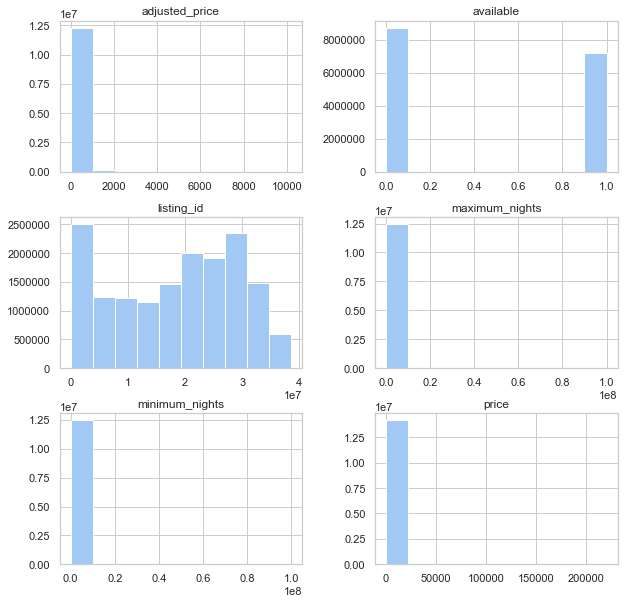

In [18]:
#Display distributions of calendar data
calendar.hist(figsize=(10,10));

### Remove Duplicate Rows

In [19]:
#Remove any duplicate rows
calendar.drop_duplicates(inplace=True)

#Updated calendar shape
print('Updated calendar shape:', calendar.shape)

Updated calendar shape: (15901917, 7)


#### Calendar Outlier Removal(Price)

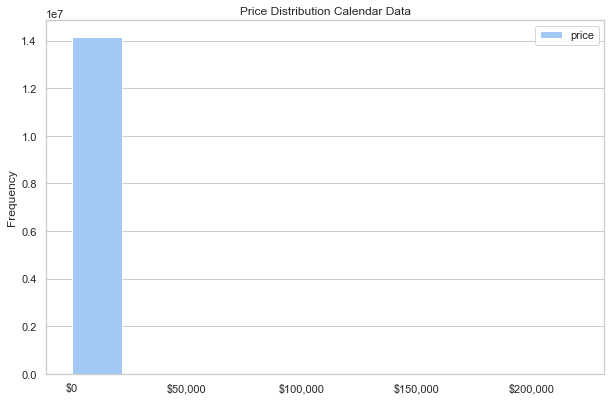

In [20]:
#Plot data
calendar.price.plot(kind = 'hist', figsize = (10,6.5),
                    legend = True, title = 'Price Distribution Calendar Data')

#Capture plot object
ax = plt.gca()

#Format x-axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Format grid lines
ax.grid(b = False, which ='major', axis = 'x')

**Identify and remove outliers using IQR

In [21]:
#Original Calendar Shape
print(calendar.shape)

(15901917, 7)


In [22]:
#Calculate IQR of price
q25 = calendar['price'].quantile(0.25)
q75= calendar['price'].quantile(0.75)
iqr = q75 - q25

#Print percentiles
print('Percentiles: 25th={:.3f}, 75th={:.3f} \nIQR= {:.3f}'.format(q25, q75, iqr))

#Calculate outlier cutoffs
cut_off =1.5 * iqr
lower, upper = q25 - cut_off, q75 + iqr

#Identify outliers
outliers = [x for x in calendar.price if x < lower or x > upper]
print("Number of outliers identified: {}".format(len(outliers)))

#Remove outliers
outliers_removed = [x for x in calendar.price if x >= lower and x <= upper]
print('Non-outlier observations: {}'.format(len(outliers_removed)))

#Update df
calendar = calendar[calendar.price.isin(outliers_removed)]
calendar.shape

Percentiles: 25th=104.000, 75th=249.000 
IQR= 145.000
Number of outliers identified: 1499300
Non-outlier observations: 12647017


(12647017, 7)

C:\Users\kishe\Miniconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning:

Unrecognized location 'top right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.



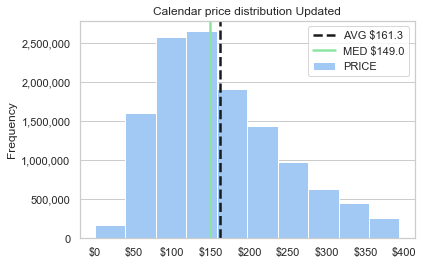

In [23]:
#Plot updated prices from calendar data
calendar.price.plot(kind = 'hist',  title = 'Calendar price distribution Updated', label = 'PRICE',
                   legend = True)

#Get plot object
ax = plt.gca()

#Capture mean and median
mean = np.mean(calendar.price)
median = np.median(calendar.price)

#Plot mean and median to histogram
ax.axvline(mean, color='k', linestyle='dashed', linewidth=2.5, label = "AVG ${:}".format(str(round(mean,2))))
ax.axvline(median, color='g', linestyle='solid', linewidth=2.5, label = "MED ${:}".format(str(round(median,2))))

#Format x-axis
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:,}".format(int(x))))

#Format y ticks
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

#Mute vertical grid lines
ax.grid(b = False, which ='major', axis = 'x')

#Show legend
plt.legend(frameon = True, loc='upper right')

In [24]:
# #Set path to write listings
# path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\02_Intermediate\calendar_cleaned.csv'

# #Write listings to path
# calendar.to_csv(path, sep='\t')